In [1]:
import xtrack as xt
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
line = xt.Line.from_json('injection_lines/injection_thin_approx_ap2.json')

Loading line from dict:   0%|          | 0/31427 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
for name in line.element_names:
    if 'Sextupole' in line[name].__class__.__name__ and 'drift' not in name:
        if hasattr(line[name]._parent, 'k2'):
            line[name]._parent.k2 = 0.0
            line[name]._parent.k2s = 0.0
    elif 'Octupole' in line[name].__class__.__name__ and 'drift' not in name:
        if hasattr(line[name]._parent, 'k3'):
            line[name]._parent.k3 = 0.0
            line[name]._parent.k3s = 0.0
    elif 'Multipole' in line[name].__class__.__name__ and 'drift' not in name:
        if hasattr(line[name], 'knl'):
            line[name].knl = np.array([0.0])
            line[name].ksl = np.array([0.0])
    elif 'Cavity' in line[name].__class__.__name__:
        if hasattr(line[name], 'voltage'):
            line[name].voltage = 0.0

In [4]:
num_turns = 1000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [5]:
#Check aperture
df_with_coll = line.check_aperture()

#OPtimize line and optics
line.build_tracker()
tw = line.twiss(method='4d')
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
line.optimize_for_tracking()

Checking aperture:   0%|          | 0/30275 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data


In [6]:
x_int = np.linspace(-12.7, 12.7, round(12.7*2/0.1)+1)
x_ext = np.linspace(-14.7, 14.7, round(14.7*2/0.1)+1)

y_int = np.linspace(-4.6683, 4.6683, round(4.6683*2/0.1)+1)
y_ext = np.linspace(-6.6683, 6.6683, round(6.6683*2/0.1)+1)

X, Y = np.meshgrid(x_ext, y_ext, indexing='xy')

x_flat = X.ravel()
y_flat = Y.ravel()

# Filter out points that fall inside the inner rectangle
mask = ~((x_flat >= x_int.min()) & (x_flat <= x_int.max()) &
         (y_flat >= y_int.min()) & (y_flat <= y_int.max()))

# Apply mask
x_hollow = x_flat[mask]
y_hollow = y_flat[mask]
x_norm = x_hollow
y_norm = y_hollow
px_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.zeros_like(x_norm)
delta = np.zeros_like(x_norm)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, method='4d')#, zeta=zeta, delta=delta)
part2 = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, method='4d')#, zeta=zeta, delta=delta)

Text(0, 0.5, 'y_norm [sigma]')

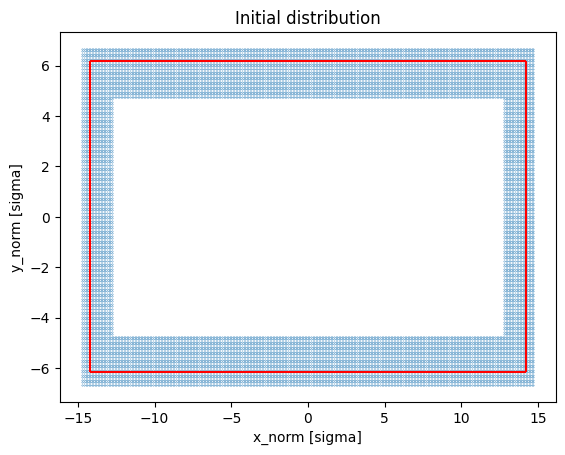

In [11]:
plt.figure()
plt.plot(
    x_hollow,
    y_hollow,
    marker='.',
    linestyle='None',
    markersize=0.5,
)
plt.vlines(-14.2, -6.1683, 6.1683, color='r')
plt.vlines(14.2, -6.1683, 6.1683, color='r')
plt.hlines(-6.1683, -14.2, 14.2, color='r')
plt.hlines(6.1683, -14.2, 14.2, color='r')
plt.title('Initial distribution')
plt.xlabel('x_norm [sigma]')
plt.ylabel('y_norm [sigma]')

In [12]:
monitor = xt.ParticlesMonitor(_context=line._context,
    num_particles=len(part.x),
    start_at_turn=0, # <-- first turn to monitor (including)
    stop_at_turn=num_turns, # <-- last turn to monitor (excluding)
)


line.discard_tracker()
line.insert_element(
    name="monitor", 
    element=monitor, 
    at=1
)
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [13]:
# Track!
#line.discard_tracker()
#line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
line.scattering.enable()
line.track(part, num_turns=num_turns, time=True, with_progress=1, freeze_longitudinal=True)
line.scattering.disable()

No xcoll elements found in line.


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
No xcoll elements found in line.


In [14]:
particles = part.to_dict()

In [15]:
idxs, death_turns, states = zip(*sorted(zip(particles['particle_id'], particles['at_turn'], particles['state'])))
idxs = np.array(idxs)
death_turns = np.array(death_turns)
states = np.array(states)

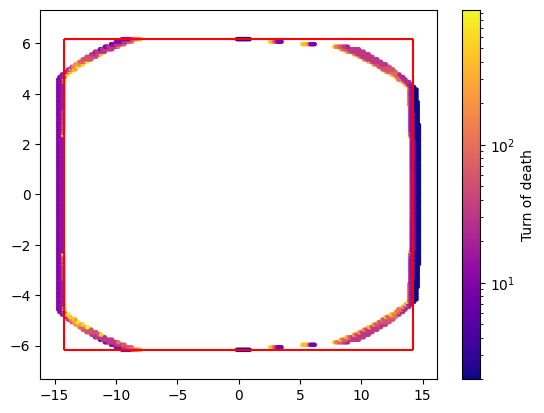

In [20]:
plt.figure()
m = (states <=0) #& (death_turns > 100)
alive = (states > 0)
sc = plt.scatter(x_hollow[m], y_hollow[m], c=death_turns[m], cmap='plasma', norm=colors.LogNorm(), marker='o', s=5)
cbar = plt.colorbar(sc)
cbar.set_label("Turn of death")
#plt.scatter(x_hollow[alive], y_hollow[alive], c='green', marker='o', s=5)
plt.hlines(6.1683, -14.2, 14.2, color='red')
plt.hlines(-6.1683, -14.2, 14.2, color='red')
plt.vlines(14.2, -6.1683, 6.1683, color='red')
plt.vlines(-14.2, -6.1683, 6.1683, color='red')

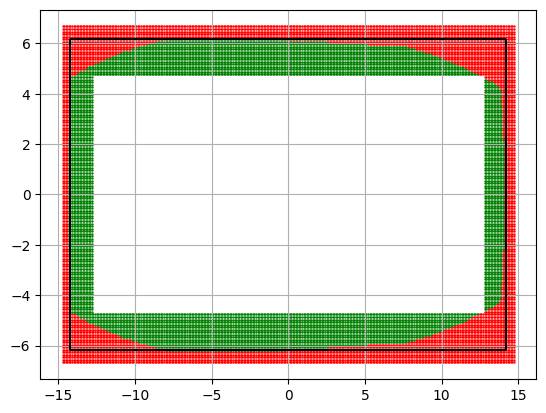

In [34]:
plt.figure()
alive = (states > 0)
plt.scatter(x_hollow[~alive], y_hollow[~alive], c='red', marker='o', s=0.5)
plt.scatter(x_hollow[alive], y_hollow[alive], c='green', marker='o', s=0.5)
plt.hlines(6.1683, -14.2, 14.2, color='black')
plt.hlines(-6.1683, -14.2, 14.2, color='black')
plt.vlines(14.2, -6.1683, 6.1683, color='black')
plt.vlines(-14.2, -6.1683, 6.1683, color='black')
plt.grid()

In [31]:
mask = (x_hollow > 14) & (x_hollow < 14.2) & (y_hollow > 2) & (y_hollow < 4)
part2.particle_id[mask]

array([8613, 8653, 8693, 8733, 8773, 8813, 8853, 8893, 8933, 8973, 9013,
       9053, 9093, 9133, 9173, 9213, 9253, 9293, 9333, 9373])

In [33]:
part.state[mask]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [82]:
part.at_turn[8613]

np.int64(279)

In [67]:
part2.x[8613]

np.float64(0.0510211928998647)

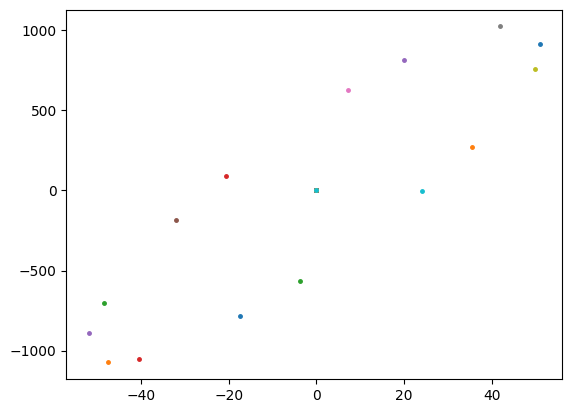

In [80]:
plt.figure()
for turn in range(num_turns):
    plt.plot(
        monitor.x[8613, turn] * 1e3,
        monitor.px[8613, turn] * 1e6,
        # color='black', 
        marker='.', 
        markersize=5,
        linestyle='None'
    )
#plot_ellipse_implicit(A=tw.gamx[2], B=2*tw.alfx[2], C=tw.betx[2], D=0, E=0, F=-np.sqrt(tw.betx[2]*nemitt_x/tw.gamma0)*nemitt_x, x_range=(-part2.x[8613], part2.x[8613]), y_range=(-part2.y[8613], part2.y[8613]), resolution=10000)

In [54]:
tw.betx[2]

np.float64(103.59922891682193)

In [53]:
np.where(tw.name=='qf.10010_entry_aper_upstream')

(array([2]),)

In [48]:
line.element_names

('qf.10010_entry_aper_upstream',
 'monitor',
 'drift_qf.10010..0',
 'qf.10010..0_aper_upstream',
 'qf.10010..0',
 'qf.10010..0_aper_downstream',
 'drift_qf.10010..1',
 'qf.10010..1_aper_upstream',
 'qf.10010..1',
 'qf.10010..1_aper_downstream',
 'drift_qf.10010..2',
 'qf.10010..2_aper_upstream',
 'qf.10010..2',
 'qf.10010..2_aper_downstream',
 'drift_qf.10010..3',
 'qf.10010..3_aper_upstream',
 'qf.10010..3',
 'qf.10010..3_aper_downstream',
 'drift_qf.10010..4',
 'qf.10010..4_aper_upstream',
 'qf.10010..4',
 'qf.10010..4_aper_downstream',
 'drift_qf.10010..5',
 'qf.10010..5_aper_upstream',
 'qf.10010..5',
 'qf.10010..5_aper_downstream',
 'drift_qf.10010..6',
 'qf.10010..6_aper_upstream',
 'qf.10010..6',
 'qf.10010..6_aper_downstream',
 'drift_qf.10010..7',
 'qf.10010..7_aper_upstream',
 'qf.10010..7',
 'qf.10010..7_aper_downstream',
 'drift_qf.10010..8',
 'qf.10010_exit_aper_downstream',
 'drift_0',
 'mba.10030_entry_aper_upstream',
 'mba.10030..entry_map_aper_upstream',
 'mba.10030..e

In [65]:
tw.alfx[2]

np.float64(-1.8579874336751747)

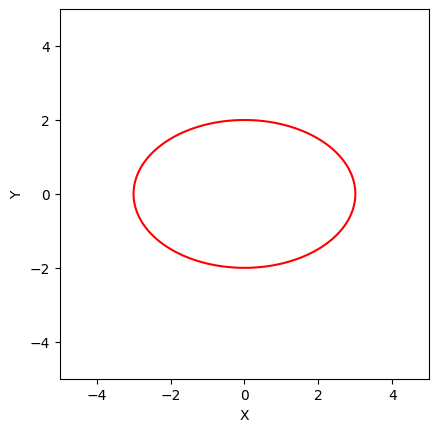

In [57]:
def plot_ellipse_implicit(A, B, C, D, E, F, x_range=(-5, 5), y_range=(-5, 5), resolution=400):
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)

    # Evaluate the implicit equation
    Z = A*X**2 + B*X*Y + C*Y**2 + D*X + E*Y + F

    plt.contour(X, Y, Z, levels=[0], colors='red')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal')
    plt.show()

# Example usage for ellipse 4x² + 9y² = 36
plot_ellipse_implicit(A=4, B=0, C=9, D=0, E=0, F=-36)

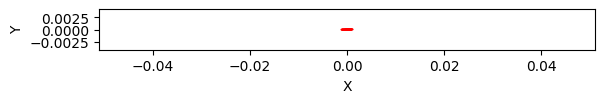

In [78]:
plot_ellipse_implicit(A=tw.gamx[2], B=2*tw.alfx[2], C=tw.betx[2], D=0, E=0, F=-np.sqrt(tw.betx[2]*nemitt_x/tw.gamma0)*nemitt_x, x_range=(-part2.x[8613], part2.x[8613]), y_range=(-part2.y[8613], part2.y[8613]), resolution=10000)

In [81]:
def evaluate_ellipse(A, B, C, D, E, F, x, y):
    return A*x**2 + B*x*y + C*y**2 + D*x + E*y + F

In [83]:
for turn in range(279):
    print(evaluate_ellipse(tw.gamx[2], 2*tw.alfx[2], tw.betx[2], 0, 0, -np.sqrt(tw.betx[2]*nemitt_x/tw.gamma0)*nemitt_x, monitor.x[8613, turn], monitor.px[8613, turn]))

2.5114573847326652e-05
2.5793646651556624e-05
2.5346823172725277e-05
2.6922616723469223e-05
2.6154029038736135e-05
2.57829521583193e-05
2.6022435381927944e-05
2.4579134500221168e-05
2.5711391155401182e-05
2.553479383805841e-05
2.576989558865967e-05
2.6877091242669314e-05
2.55810596984993e-05
2.5971653192236217e-05
2.547930511981681e-05
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.2660709749424986e-08
-1.26607097494